In [1]:
setwd('../../')
source('.Rprofile')
setwd('./benchmark/analysis')

library(ggplot2)
library(tidyverse)
library(ggpubr)
library(reshape2)
library(patchwork)

[1] "/lustre/grp/gglab/xiacr/SLAT/renv/library/R-4.1/x86_64-pc-linux-gnu"         
[2] "/lustre/grp/gglab/xiacr/SLAT/renv/sandbox/R-4.1/x86_64-pc-linux-gnu/90a76c8d"


Warning message in system2("poetry", c("env", "info", "--path"), stdout = TRUE):
“running command ''poetry' env info --path' had status 1”


python:         /lustre/grp/gglab/xiacr/SLAT/conda/bin/python
libpython:      /lustre/grp/gglab/xiacr/SLAT/conda/lib/libpython3.8.so
pythonhome:     /lustre/grp/gglab/xiacr/SLAT/conda:/lustre/grp/gglab/xiacr/SLAT/conda
version:        3.8.17 | packaged by conda-forge | (default, Jun 16 2023, 07:06:00)  [GCC 11.4.0]
numpy:          /lustre/grp/gglab/xiacr/SLAT/conda/lib/python3.8/site-packages/numpy
numpy_version:  1.24.4

NOTE: Python version was forced by use_python function
[1] "/lustre/grp/gglab/xiacr/SLAT/conda/lib:/lustre/grp/gglab/xiacr/SLAT/resource/R/lib/R/lib:/usr/local/lib:/flash/grp/gglab/xiacr/SpatialLR-dev/resource/jdk1.8.0_361/jre/lib/i386/client:/opt/slurm-22.05.2/lib:/opt/slurm-22.05.2/lib/slurm:"


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
data <- read_csv('../split/split_data.csv')
data$cells <- as.numeric(data$cells)
data <- data[data$global_score > 0,]
data <- data[data$cells == 0,] %>% filter(!method %in% c('SLAT', 'SLAT_harmony', 'PCA')) %>% 
        mutate(method = replace(method, method == 'SLAT_dpca', 'SLAT'))
data[nrow(data) + 1,] <- list("stereo_mouse_embryo",0,0,0.5,'PASTE',NA,NA,NA,NA,NA,NA) # PASTE can not run on Stereo-seq
data %>% head(3)

Rows: 112 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, method
dbl (9): cells, seed, split_ratio, celltype_score, edge_score, euclidean_dis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


dataset,cells,seed,split_ratio,method,celltype_score,edge_score,euclidean_dis,global_score,region_score,run_time
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
merfish_mouse_hypothalamic,0,0,0.5,Harmony,0.8244697,-44.15247,0.36976342,0.3107900,0.3722717,13.02296
merfish_mouse_hypothalamic,0,0,0.5,PASTE,0.3338457,-27.72395,0.02124764,0.2969567,0.8592069,45.02599
merfish_mouse_hypothalamic,0,0,0.5,SLAT,0.7347064,-35.80018,0.04396781,0.5699354,0.7820473,20.36497


In [5]:
data <- data %>% 
  mutate(across('dataset', str_replace, 'merfish_mouse_hypothalamic', 'MERFISH')) %>%
  mutate(across('dataset', str_replace, 'visium_human_DLPFC', 'Visium')) %>%
  mutate(across('dataset', str_replace, 'stereo_mouse_embryo', 'Stereo-seq'))
data$dataset <- factor(data$dataset, levels = c('Visium','MERFISH','Stereo-seq'))
data$method <- factor(data$method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))
data %>% tail()

dataset,cells,seed,split_ratio,method,celltype_score,edge_score,euclidean_dis,global_score,region_score,run_time
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Visium,0,7,0.5,Harmony,0.9141442,-44.02091,0.15643353,0.6708861,0.7072097,9.992527
Visium,0,7,0.5,PASTE,0.7771051,-26.10677,0.02779428,0.6714364,0.8381948,33.180135
Visium,0,7,0.5,SLAT,0.8403963,-30.49532,0.02617893,0.7523390,0.8800220,23.544304
Visium,0,7,0.5,STAGATE,0.8117777,-31.09521,0.03267062,0.7154651,0.8701156,18.935319
Visium,0,7,0.5,Seurat,0.8673638,-44.63952,0.21074426,0.6318107,0.6851954,44.521000
Stereo-seq,0,0,0.5,PASTE,NA,NA,NA,NA,NA,NA


Warning message in base::min(x, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in base::max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


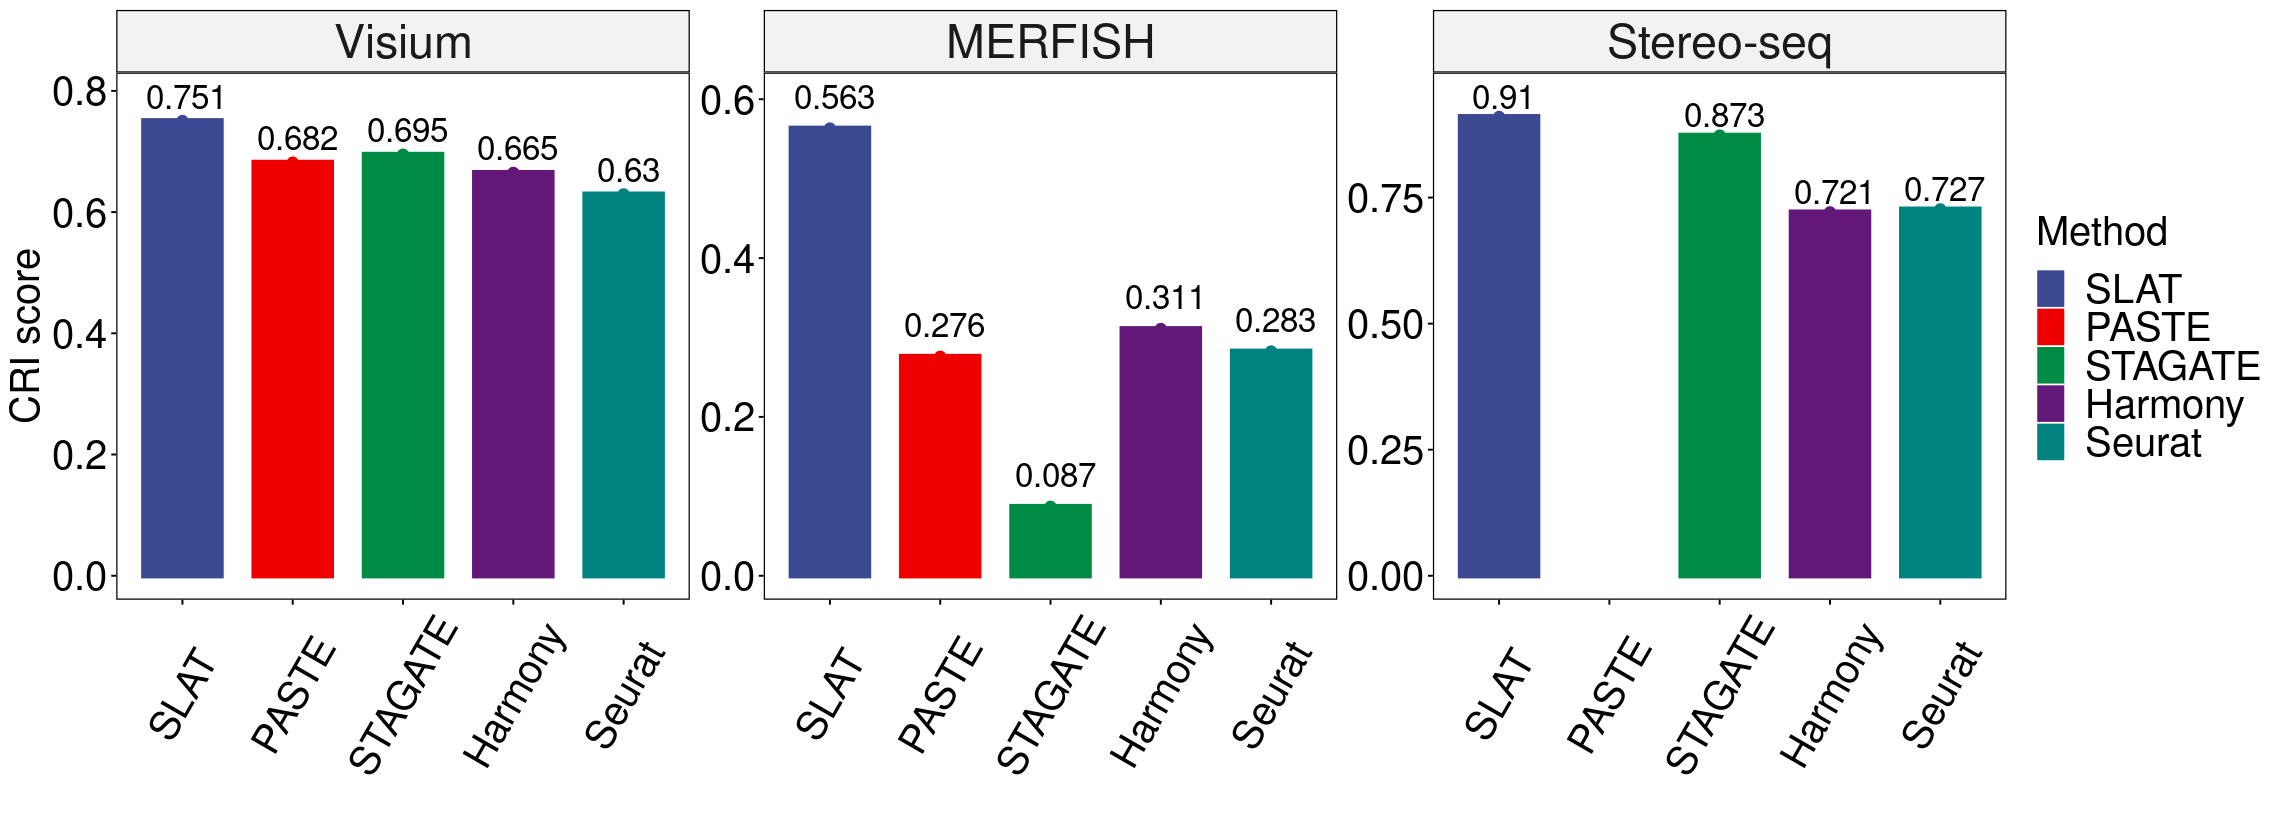

In [4]:
options(repr.plot.width=19, repr.plot.height=7)
ggbarplot(data, x="method", y="global_score", fill='method', color='method', add="mean_se", error.plot="pointrange",
        palette='aaas', xlab='' ,ylab='CRI score', size=1.5, lab.size=5, facet.by='dataset',label = F, label.pos = "out",
        legend.title = 'Method') %>%
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=24, font.x = 28) +
stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.04, label = paste("", round(mean(x), 3))), geom="text",size=7) +
facet_wrap(~dataset, scales="free")+
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))


Warning message in base::min(x, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in base::max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


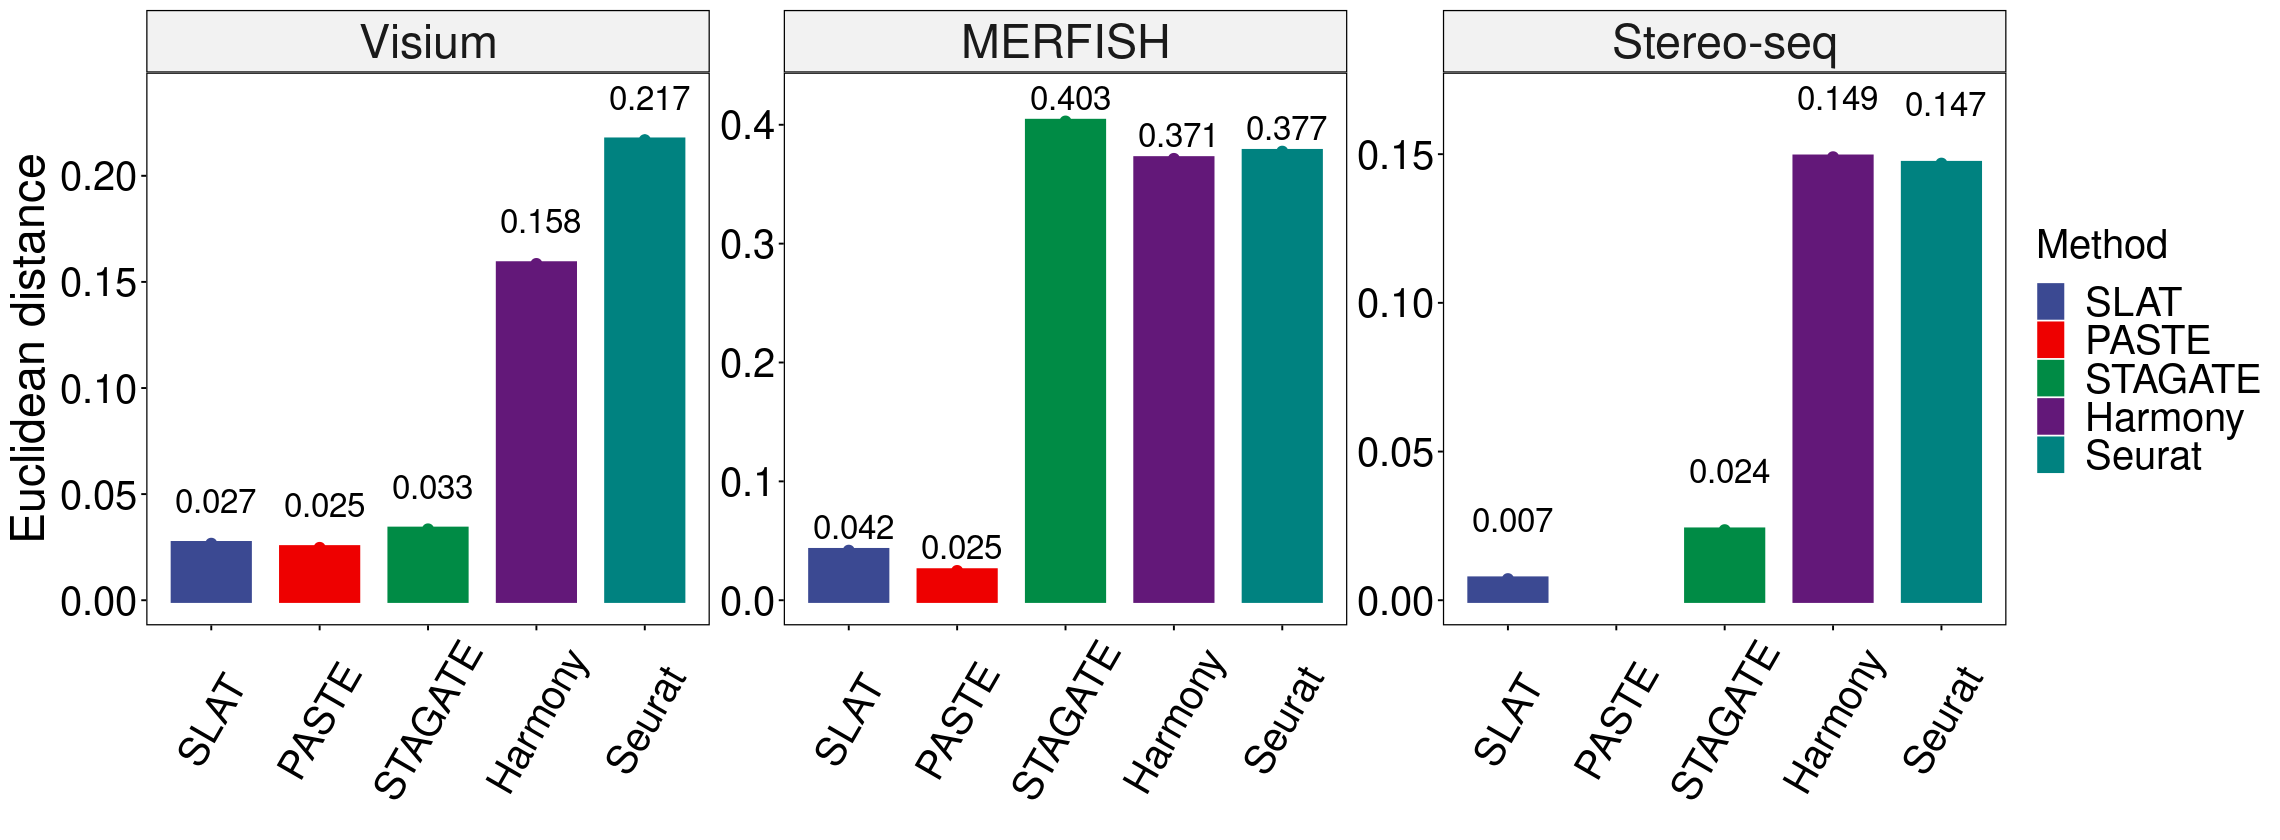

In [6]:
options(repr.plot.width=19, repr.plot.height=7)
ggbarplot(data, x="method", y="euclidean_dis", fill='method', color='method', add="mean_se", error.plot="pointrange",
        palette='aaas', xlab='' ,ylab='Euclidean distance', size=1.5, lab.size=5, facet.by='dataset',label = F, label.pos = "out",
        legend.title = 'Method') %>% 
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28) +
stat_summary(fun.data = function(x) data.frame(y = mean(x)+0.02, label = paste("", round(mean(x), 3))), geom="text",size=7) +
facet_wrap(~dataset, scales="free")+
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))


Warning message in base::min(x, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in base::max(x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in stats::qt(ci/2 + 0.5, data_sum$length - 1):
“NaNs produced”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


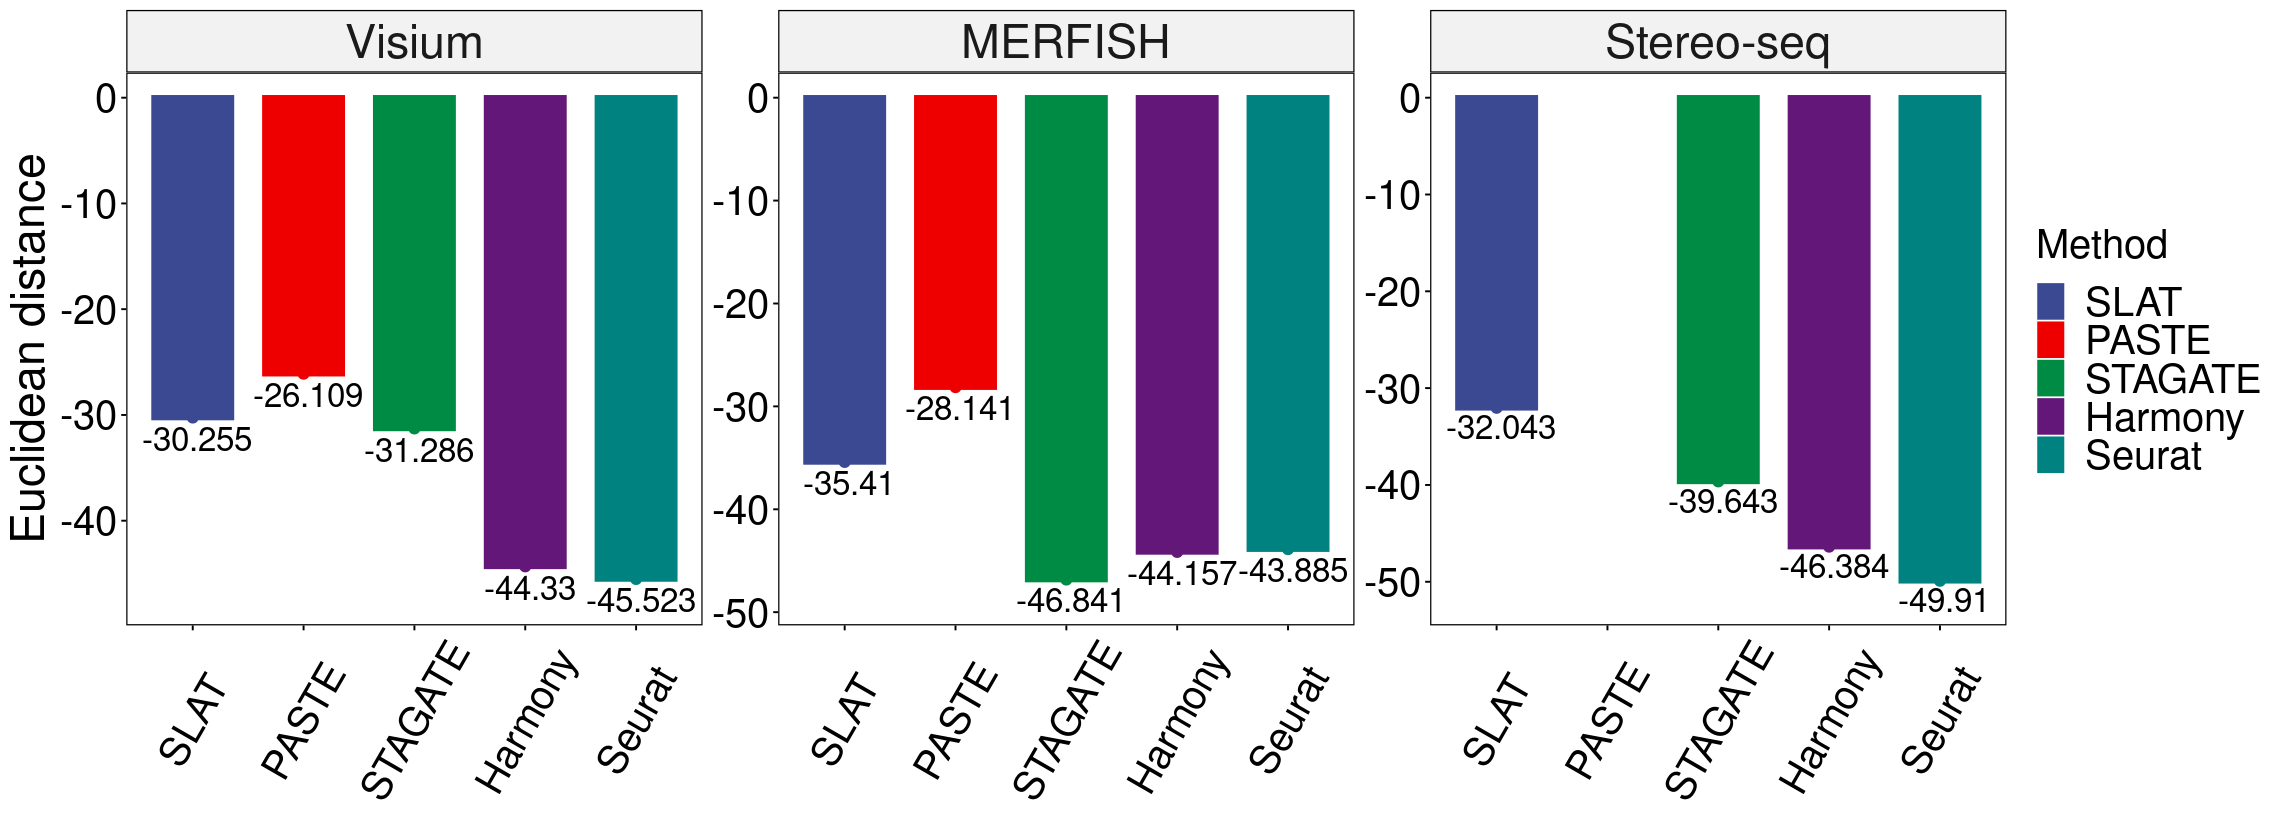

In [7]:
options(repr.plot.width=19, repr.plot.height=7)
ggbarplot(data, x="method", y="edge_score", fill='method', color='method', add="mean_se", error.plot="pointrange",
        palette='aaas', xlab='' ,ylab='Euclidean distance', size=1.5, lab.size=5, facet.by='dataset',label = F, label.pos = "out",
        legend.title = 'Method') %>% 
ggpar(legend='right', font.legend=24, font.subtitle=24, font.xtickslab=24, font.ytickslab=24, font.y=28) +
stat_summary(fun.data = function(x) data.frame(y = mean(x)-2, label = paste("", round(mean(x), 3))), geom="text",size=7) +
facet_wrap(~dataset, scales="free")+
theme(axis.text.x=element_text(angle=60, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=28))


[1] "Seurat"
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8717666            0.846863         0.7495184
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]          0.851541           0.7749725          0.681962
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8657815           0.7883875          0.695033
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7080352           0.9054073         0.6651073
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.6880848           0.8601403         0.6296092
[1] "Seurat"
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7834307           0.7190286           0.56421
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8394943           0.3186674         0.2760529
[1] "MERFISH"
     mean_reg

Warning message:
“Removed 4 rows containing missing values (`geom_text()`).”


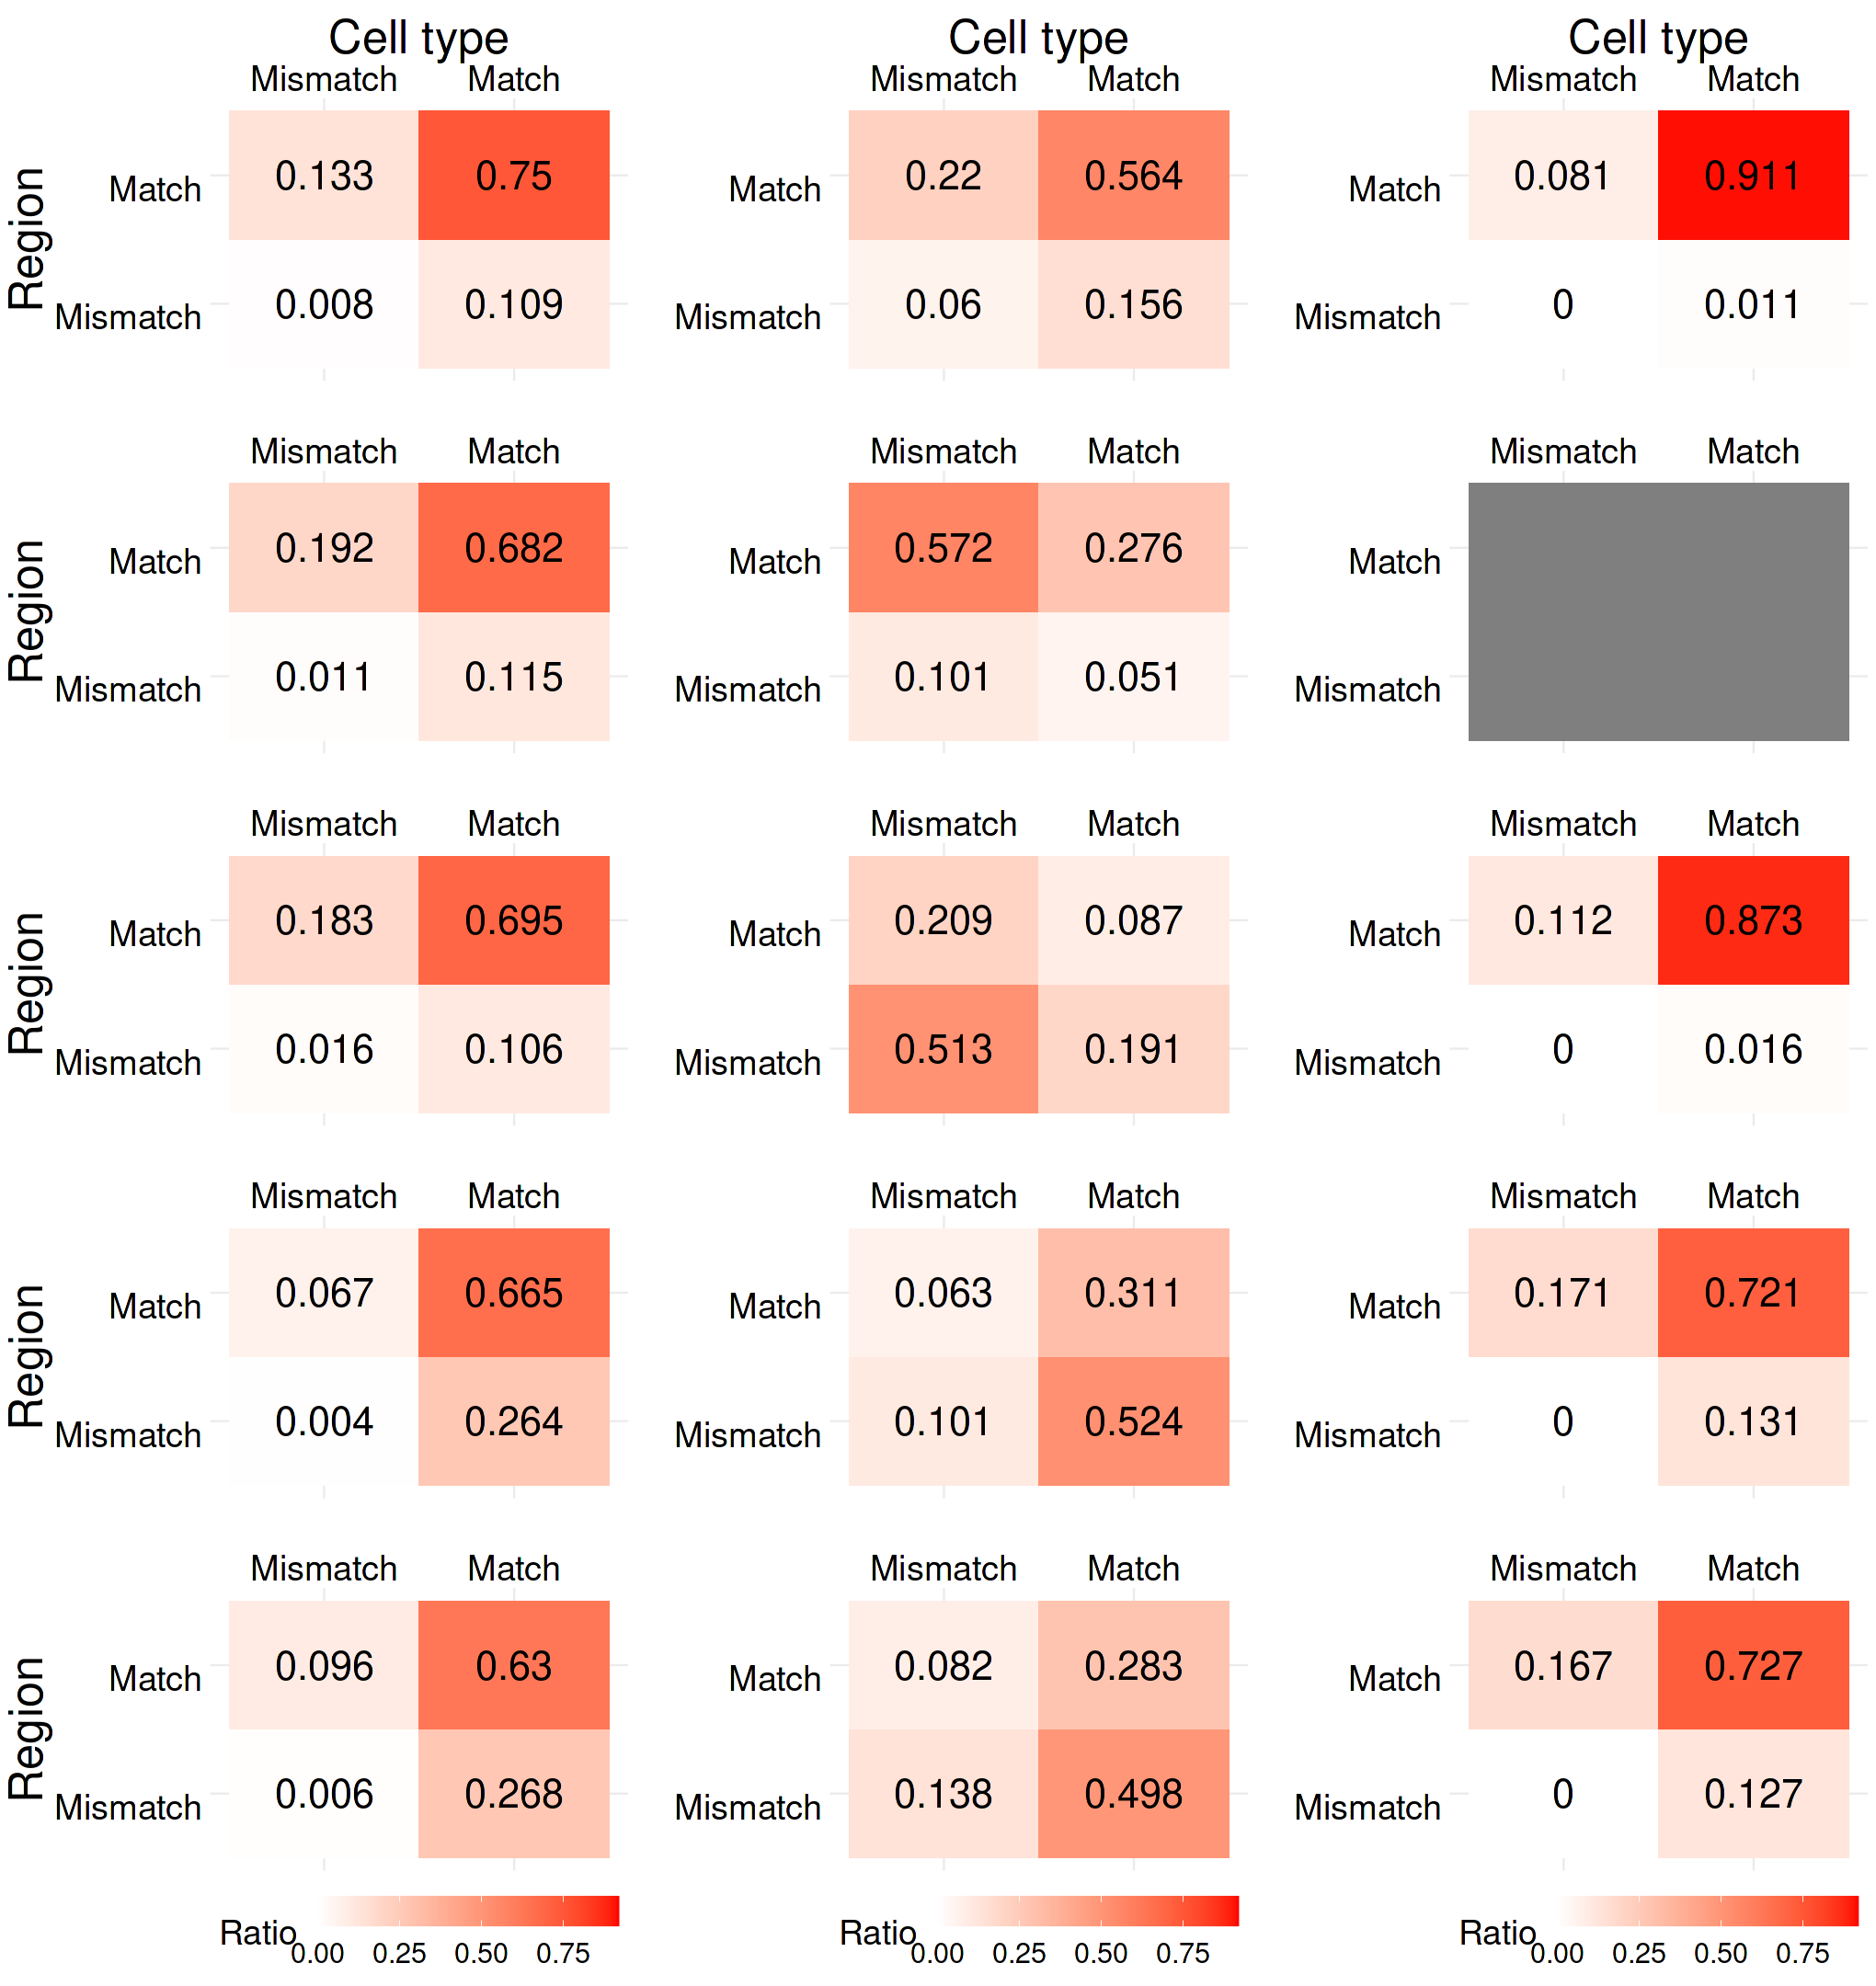

In [15]:
options(repr.plot.width=4, repr.plot.height=3)
p2_list <- list()
j <- 1 # column for methods
for(datasets in c('Visium','MERFISH','Stereo-seq')){
    i <- 1 # row for dataset
    p_list <- list()
    print(methods)
    for(methods in c('SLAT','PASTE','STAGATE', 'Harmony', 'Seurat')){
        print(datasets)
        data_method <- data %>% filter(method == methods, dataset == datasets)  %>% 
            summarise(mean_region_score = mean(region_score), mean_celltype_score = mean(celltype_score), mean_global_score = mean(global_score)) %>% 
            as.matrix()
        print(data_method)
        confusion_matrix <- matrix(0, nrow = 2, ncol = 2)
        confusion_matrix[2,2] <- data_method[1,3]
        confusion_matrix[1,2] <- data_method[1,1] * (1 - data_method[1,2])
        confusion_matrix[2,1] <- data_method[1,2] * (1 - data_method[1,1])
        confusion_matrix[1,1] <- 1 - confusion_matrix[1,2] - confusion_matrix[2,2] - confusion_matrix[2,1]
        rownames(confusion_matrix) <- c('Mismatch', 'Match')
        colnames(confusion_matrix) <- c('Mismatch', 'Match')
        confusion_matrix <- confusion_matrix %>% melt()
        colnames(confusion_matrix) <- c('Cell_type', 'Region', 'Ratio')
        # print(confusion_matrix)
        # replace element which smaller than 0 with 0
        confusion_matrix$Ratio[confusion_matrix$Ratio < 0] <- 0

        p <- ggplot(confusion_matrix, aes(x = Cell_type, y = Region, fill = Ratio)) + 
            geom_tile() + 
            geom_text(aes(x = Cell_type, y = Region, label = round(Ratio, digits = 3)), color = "black", size = 9) + 
            scale_fill_gradient2(low = "white", high = "red", limit = c(-0.01, 0.92)) +
            labs(x = 'Cell type', y = 'Region', title = paste0(methods,datasets)) + 
            scale_x_discrete(position = "top") + 
            theme_minimal() +
            theme(  text = element_text(size = 28),
                    axis.text = element_text(vjust = 1, hjust = 0.5, color = "black"),
                    axis.title = element_text(size = 30),
                    plot.title = element_text(size = 30, hjust = 0.5),
                    legend.title = element_text(size = 22),
                    legend.text = element_text(size = 18),
                    axis.ticks = element_blank(),
                    plot.margin = unit(c(0,0,0,0), "pt",),
                    legend.position = "bottom",
                    legend.key.width = unit(40, "pt"),
                    legend.key.height = unit(20, "pt")
                )

        if (i != 5) {p <- p + theme(legend.position = "none") }
        if (i > 1) {p <- p + labs(x='') }
        if (j > 1) {p <- p + labs(y='') }
        if (TRUE) {p <- p + theme(plot.title = element_blank())}
        # print(p)
        p_list[[i]] <- p
        i <- i + 1
        }
    p2 <-  do.call(patchwork::wrap_plots, c(p_list, ncol = 1))
    p2_list[[j]] <- p2
    j <- j + 1
}

options(repr.plot.width = 17, repr.plot.height = 18)
do.call(patchwork::wrap_plots, c(p2_list, ncol = 3))

[1] "STAGATE"
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.8717666            0.846863         0.7495184
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7080352           0.9054073         0.6651073
[1] "Visium"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.6880848           0.8601403         0.6296092
[1] "Seurat"
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.7834307           0.7190286           0.56421
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.3662389           0.8274285         0.3109822
[1] "MERFISH"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.3525208           0.7687903         0.2826622
[1] "Seurat"
[1] "Stereo-seq"
     mean_region_score mean_celltype_score mean_global_score
[1,]         0.9881427            0.918494         0.9109868
[1] "Ste

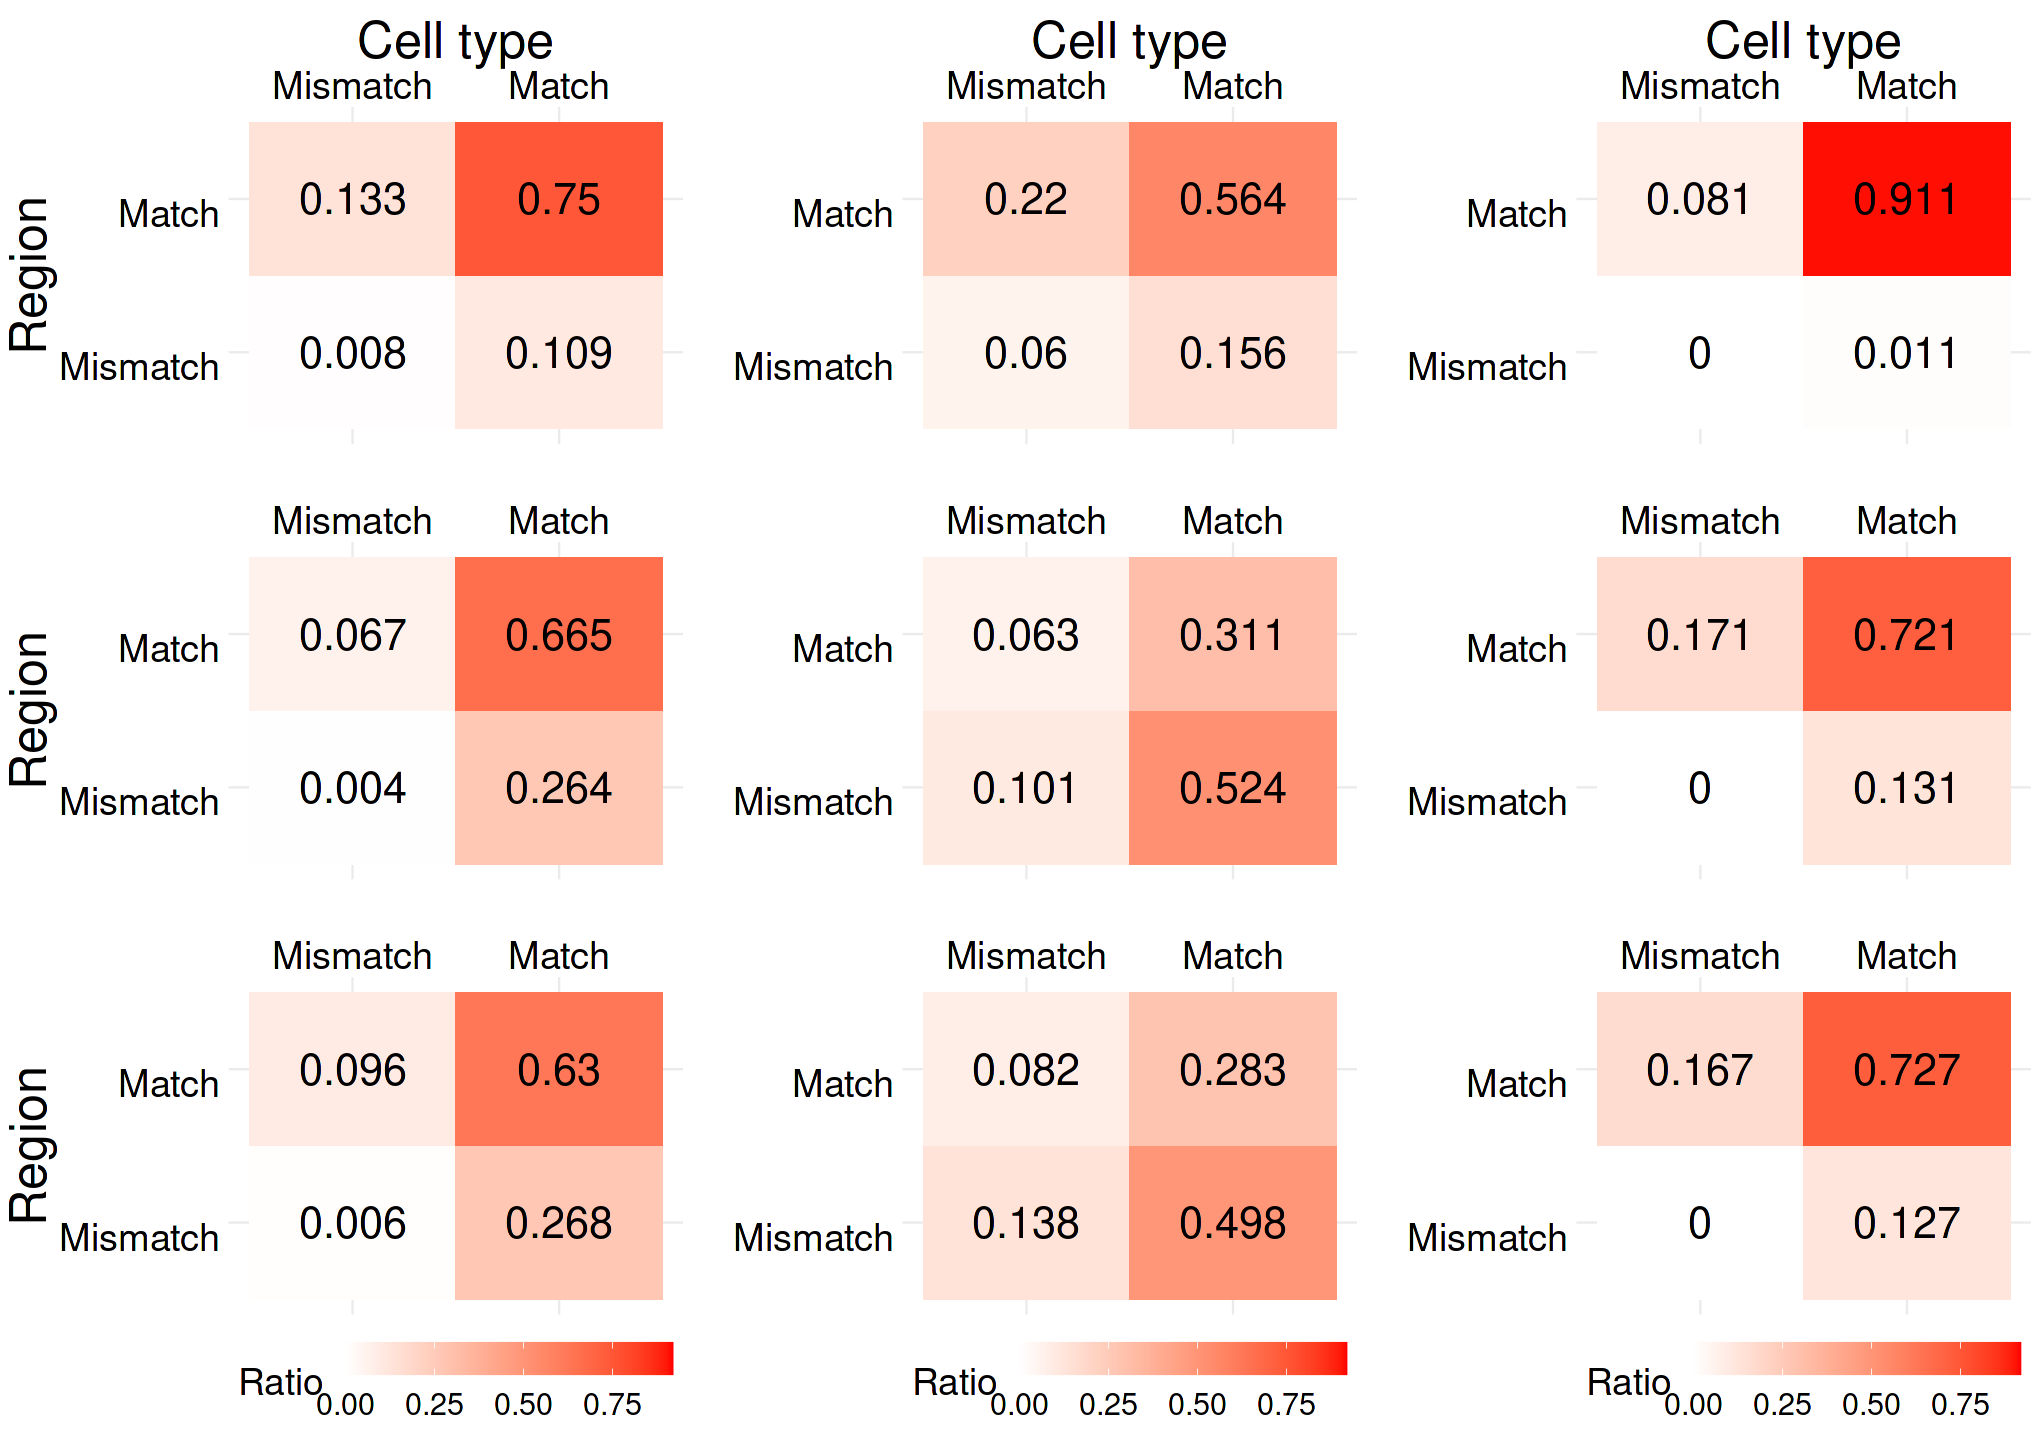

In [7]:
options(repr.plot.width=4, repr.plot.height=3)
p2_list <- list()
j <- 1 # column for methods
for(datasets in c('Visium','MERFISH','Stereo-seq')){
    i <- 1 # row for dataset
    p_list <- list()
    print(methods)
    for(methods in c('SLAT','Harmony','Seurat')){
        print(datasets)
        data_method <- data %>% filter(method == methods, dataset == datasets)  %>% 
            summarise(mean_region_score = mean(region_score), mean_celltype_score = mean(celltype_score), mean_global_score = mean(global_score)) %>% 
            as.matrix()
        print(data_method)
        confusion_matrix <- matrix(0, nrow = 2, ncol = 2)
        confusion_matrix[2,2] <- data_method[1,3]
        confusion_matrix[1,2] <- data_method[1,1] * (1 - data_method[1,2])
        confusion_matrix[2,1] <- data_method[1,2] * (1 - data_method[1,1])
        confusion_matrix[1,1] <- 1 - confusion_matrix[1,2] - confusion_matrix[2,2] - confusion_matrix[2,1]
        rownames(confusion_matrix) <- c('Mismatch', 'Match')
        colnames(confusion_matrix) <- c('Mismatch', 'Match')
        confusion_matrix <- confusion_matrix %>% melt()
        colnames(confusion_matrix) <- c('Cell_type', 'Region', 'Ratio')
        # print(confusion_matrix)
        # replace element which smaller than 0 with 0
        confusion_matrix$Ratio[confusion_matrix$Ratio < 0] <- 0

        p <- ggplot(confusion_matrix, aes(x = Cell_type, y = Region, fill = Ratio)) + 
            geom_tile() + 
            geom_text(aes(x = Cell_type, y = Region, label = round(Ratio, digits = 3)), color = "black", size = 9) + 
            scale_fill_gradient2(low = "white", high = "red", limit = c(-0.01, 0.92)) +
            labs(x = 'Cell type', y = 'Region', title = paste0(methods,datasets)) + 
            scale_x_discrete(position = "top") + 
            theme_minimal() +
            theme(  text = element_text(size = 28),
                    axis.text = element_text(vjust = 1, hjust = 0.5, color = "black"),
                    axis.title = element_text(size = 30),
                    plot.title = element_text(size = 30, hjust = 0.5),
                    legend.title = element_text(size = 22),
                    legend.text = element_text(size = 18),
                    axis.ticks = element_blank(),
                    plot.margin = unit(c(0,0,0,0), "pt",),
                    legend.position = "bottom",
                    legend.key.width = unit(40, "pt"),
                    legend.key.height = unit(20, "pt")
                )

        if (i != 3) {p <- p + theme(legend.position = "none") }
        if (i > 1) {p <- p + labs(x='') }
        if (j > 1) {p <- p + labs(y='') }
        if (TRUE) {p <- p + theme(plot.title = element_blank())}
        # print(p)
        p_list[[i]] <- p
        i <- i + 1
        }
    p2 <-  do.call(patchwork::wrap_plots, c(p_list, ncol = 1))
    p2_list[[j]] <- p2
    j <- j + 1
}

options(repr.plot.width = 17, repr.plot.height = 12)
do.call(patchwork::wrap_plots, c(p2_list, ncol = 3))